# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage
from scipy.fft import dctn, idctn
import cv2 # for img conversiont 


# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

C:\Users\aairinei\AppData\Local\Temp\ipykernel_28532\866361824.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


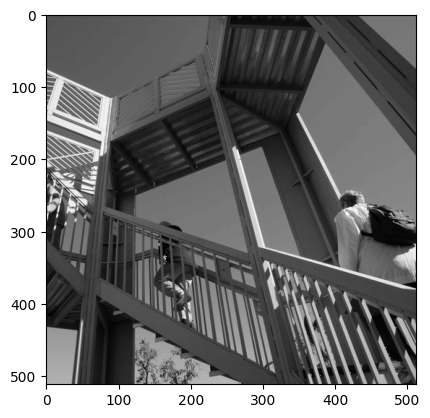

In [43]:
X = misc.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

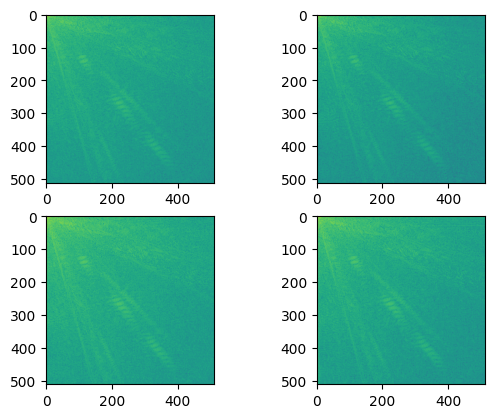

In [44]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)
freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

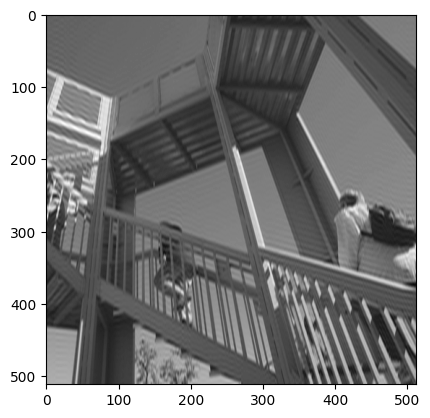

In [45]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. opțional compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

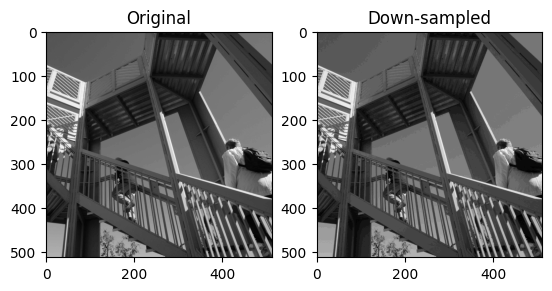

In [46]:
Q_down = 10

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down)

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

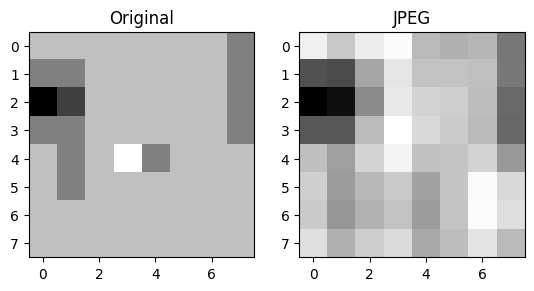

Componente în frecvență:64
Componente în frecvență după cuantizare: 14


In [47]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

# Encoding
def jpeg_block(block):
      assert block.shape == (8,8)
      y = dctn(block)
      y_jpeg = Q_jpeg*np.round(y/Q_jpeg)
      return y_jpeg

def unjpeg_block(block):
      return idctn(block)

y_jpeg = jpeg_block(X[:8, :8])

# Decoding
x_jpeg = unjpeg_block(y_jpeg)

# Results
y_nnz = np.count_nonzero(y)
y_jpeg_nnz = np.count_nonzero(y_jpeg)

plt.subplot(121).imshow(x, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(x_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))

# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.

# Exercitiul 1

In [48]:

img = X.copy()

# split into 8 * 8 blocks, return matrix of said blocks
def partition_array(arr, block_size=(8, 8)):
    # zero pad in case shape is not divisible by block size
    pad_height = (-len(arr)) % block_size[0]
    pad_width = (-len(arr[0])) % block_size[1]
    padded_arr = np.pad(arr, ((0, pad_height), (0, pad_width)), mode='constant')

    height = len(arr) // block_size[0]
    width = len(arr[0]) // block_size[1]
    blocks = [[[] for _ in range(width)] for _ in range(height)]
    for i in range(0, padded_arr.shape[0], block_size[0]):
        for j in range(0, padded_arr.shape[1], block_size[1]):
            block = padded_arr[i:i + block_size[0], j:j + block_size[1]]
            blocks[i//block_size[0]][j//block_size[1]] = block

    return np.array(blocks)

# TODO: add logic to unpad?
def merge_blocks(blocks):
    num_blocks_height = blocks.shape[0]
    num_blocks_width = blocks.shape[1]
    reconstructed_padded = np.block([[blocks[i, j] for j in range(num_blocks_width)] for i in range(num_blocks_height)])

    return reconstructed_padded

block_img = partition_array(img)
reconstructed = merge_blocks(block_img)
reconstructed.resize(img.shape)
assert np.array_equal(img,reconstructed)
block_img.shape

(64, 64, 8, 8)

In [49]:
def jpeg_block_img(block_img):
    ans = np.zeros(block_img.shape)
    for (i,line) in enumerate(block_img):
        for (j,block) in enumerate(line):
            ans[i][j] = jpeg_block(block)
    return ans

def unjpeg_block_image(jpeg_img):
    ans = np.zeros(jpeg_img.shape)
    for (i,line) in enumerate(jpeg_img):
        for (j,block) in enumerate(line):
            ans[i][j] = unjpeg_block(block)
    return ans

jpeg = jpeg_block_img(block_img)
reconstructed_block = unjpeg_block_image(jpeg)


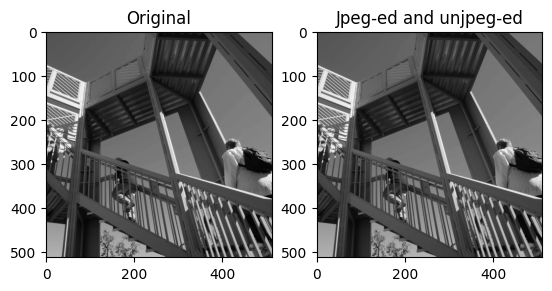

In [50]:
def jpeg_encode(img):
    block_img = partition_array(img)
    return jpeg_block_img(block_img)

def jpeg_decode(img):
    block_img = unjpeg_block_image(img)
    return merge_blocks(block_img)

tst_img = X.copy()

jpeg = jpeg_encode(tst_img)
recover = jpeg_decode(jpeg)

# visually test that its ok :))
plt.subplot(121).imshow(tst_img, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(recover, cmap=plt.cm.gray)
plt.title('Jpeg-ed and unjpeg-ed')
plt.show()

# Exercitiul 2

C:\Users\aairinei\AppData\Local\Temp\ipykernel_28532\1203734379.py:1: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  X = misc.face() # raton <3


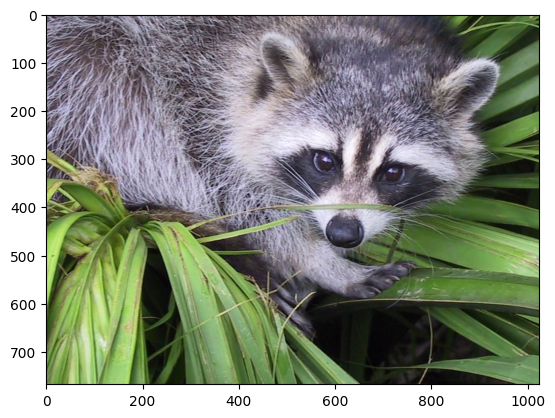

(768, 1024, 3)

In [52]:
X = misc.face() # raton <3
plt.imshow(X)
plt.show()
X.shape

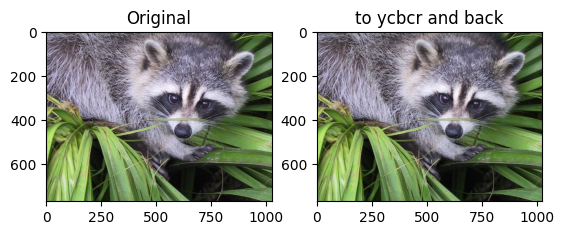

(768, 1024, 3)

In [59]:
def rgb_to_ycbcr(rgb_image):
    matrix = np.array([
        [0.299, 0.587, 0.114],
        [-0.168736, -0.331264, 0.5],
        [0.5, -0.418688, -0.081312]
    ])
    offset = np.array([0, 128, 128])
    ycbcr_image = np.dot(rgb_image, matrix.T) + offset
    ycbcr_image = np.clip(ycbcr_image, 0, 255)
    return ycbcr_image.astype(np.uint8)

def ycbcr_to_rgb(ycbcr_image):
    matrix = np.array([
        [1.0, 0.0, 1.402],
        [1.0, -0.344136, -0.714136],
        [1.0, 1.772, 0.0]
    ])
    offset = np.array([0, -128, -128])
    rgb_image = np.dot(ycbcr_image + offset, matrix.T)
    rgb_image = np.clip(rgb_image, 0, 255)
    return rgb_image.astype(np.uint8)

tst_img = X.copy()
ycrcb_img = rgb_to_ycbcr(X)
recover_img = ycbcr_to_rgb(ycrcb_img)

plt.subplot(121).imshow(tst_img, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(recover_img, cmap=plt.cm.gray)
plt.title('to ycbcr and back')
plt.show()

ycrcb_img.shape

absolute error 14293768
avg error per pixel 6.05848863389757


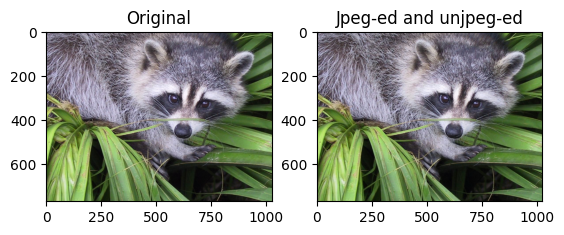

In [80]:
def jpeg_rgb(img):
    ycbcr = rgb_to_ycbcr(img)
    assert img.shape[2] == 3
    jpeg_channels = []
    for c_id in range(3):
        channel = ycbcr[:,:,c_id]
        jpeg_channels.append(jpeg_encode(channel))

    return np.array(jpeg_channels)

def unjpeg_rgb(channels):
    img = []
    assert len(channels) == 3
    for channel in channels:
        decoded = jpeg_decode(channel)
        img.append(decoded)
    img = np.array(img)
    img = img.transpose(1, 2, 0)
    return ycbcr_to_rgb(img)

tst_img = X.copy()
jpeg_img = jpeg_rgb(tst_img)
recover = unjpeg_rgb(jpeg_img)
recover.shape

off = np.sum(np.absolute(tst_img - recover))
print(f"absolute error {off}")
print(f"avg error per pixel {off / np.prod(tst_img.shape)}")

plt.subplot(121).imshow(tst_img, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(recover, cmap=plt.cm.gray)
plt.title('Jpeg-ed and unjpeg-ed')
plt.show()

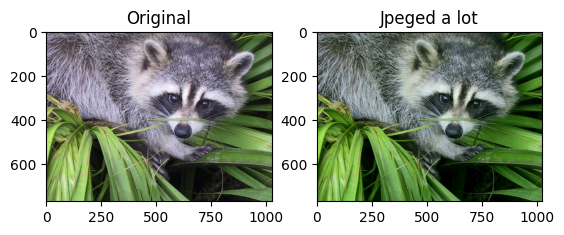

In [76]:
tst_img = X.copy()
orig_img = tst_img.copy()

for i in range(15):
    jpeg_img = jpeg_rgb(tst_img)
    recover = unjpeg_rgb(jpeg_img)
    tst_img = recover

plt.subplot(121).imshow(orig_img, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(tst_img, cmap=plt.cm.gray)
plt.title('Jpeged a lot')
plt.show()